### Preprocessing Data

In [38]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
from itertools import islice
import numpy as np

filename_infrastructure = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
filename_boundaries = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'

In [2]:
infrastructure = pd.read_csv(filename_infrastructure)
infrastructure = gpd.GeoDataFrame(infrastructure)
infrastructure['the_geom'] = infrastructure['the_geom'].apply(shapely.wkt.loads)
infrastructure.set_geometry('the_geom', inplace=True)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_12259/3234150003.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  infrastructure = pd.read_csv(filename_infrastructure)


In [3]:
filter = gpd.read_file(filename_boundaries)
filter = filter[filter['boro_name'] == 'Manhattan']

<AxesSubplot:>

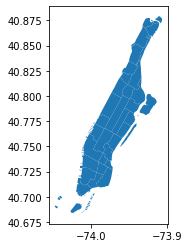

In [4]:
filter.plot()

In [5]:
infrastructure = infrastructure.sjoin(filter) # restrict streets to filter
if 'index_right' in infrastructure.columns:
    infrastructure.drop(columns=['index_right'], inplace=True)

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


<AxesSubplot:>

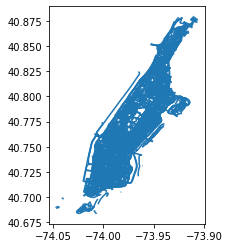

In [6]:
infrastructure.plot()

In [7]:
def get_neighbors(geometry, id):
    neighbors = infrastructure['PHYSICALID'].loc[infrastructure['the_geom'].intersects(geometry)].tolist()
    neighbors.remove(id)
    return neighbors

# Build column with adjacent links
infrastructure['neighbors'] = infrastructure.apply(lambda x: get_neighbors(x.the_geom, x.PHYSICALID), axis=1)

# Additional constraints like which way to turn, which roads meet at intersection

In [30]:
collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_12259/1014587558.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])


In [42]:
markers = ['bike', 'bicyc', 'e - b', 'e-bik', 'e-unicycle']
mask = collisions['VEHICLE TYPE CODE 1'].str.contains('bike') # placeholder
# other names: bk, bicycle, bicyc
for i in [1,2,3,4,5]:
    for marker in markers:
        mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains(marker, case=False)

# Restrict to collisions involving bikes
collisions = collisions.loc[mask]

In [10]:
collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

In [11]:
collisions.sjoin(filter)
if 'index_right' in collisions.columns:
    collisions.drop(columns=['index_right'], inplace=True)

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [12]:
collisions = collisions.sjoin_nearest(infrastructure, max_distance=0.0001)

In [13]:
collisions['CRASH DATE'] = pd.to_datetime(collisions['CRASH DATE'])
collisions.groupby([collisions['CRASH DATE'].dt.year]).count()
## So let's start in 2016!

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,BIKE_TRAFD,SHAPE_Leng,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,neighbors
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,2,2,2,2,2,2,2,2,2,0,...,0,2,2,2,2,2,2,2,2,2
2013,1,1,1,1,1,1,1,0,0,1,...,0,1,1,1,1,1,1,1,1,1
2014,2,2,2,2,2,2,2,1,1,1,...,0,2,2,2,2,2,2,2,2,2
2015,3,3,3,3,3,3,3,2,2,1,...,0,3,3,3,3,3,3,3,3,3
2016,1930,1930,1560,1560,1930,1930,1930,1421,1130,509,...,774,1930,1930,1930,1930,1930,1930,1930,1930,1930
2017,2191,2191,1713,1713,2191,2191,2191,1595,1153,596,...,902,2191,2191,2191,2191,2191,2191,2191,2191,2191
2018,2154,2154,1769,1769,2154,2154,2154,1617,1254,537,...,862,2154,2154,2154,2154,2154,2154,2154,2154,2154
2019,2194,2194,1744,1744,2194,2194,2194,1645,1219,549,...,887,2194,2194,2194,2194,2194,2194,2194,2194,2194
2020,1811,1811,1367,1367,1811,1811,1811,1424,1010,387,...,643,1811,1811,1811,1811,1811,1811,1811,1811,1811


In [14]:

start_date = pd.Timestamp('2016-01-01')
collisions = collisions.loc[collisions['CRASH DATE'] > start_date]

In [15]:
year = '2016'
month = '01'
filename_citibike = f'data_unwrangled/citibike/{year}{month}-citibike-tripdata.csv'
citibike_yearmonth = pd.read_csv(filename_citibike)

In [16]:
citibike_yearmonth = gpd.GeoDataFrame(citibike_yearmonth)
citibike_yearmonth['start_geom'] = gpd.points_from_xy(citibike_yearmonth['start station longitude'], citibike_yearmonth['start station latitude'])
citibike_yearmonth['end_geom'] = gpd.points_from_xy(citibike_yearmonth['end station longitude'], citibike_yearmonth['end station latitude'])

In [17]:
for geom in ['start_geom', 'end_geom']:
    citibike_yearmonth.set_geometry(geom, inplace=True)
    citibike_yearmonth = citibike_yearmonth.sjoin(filter)
    if 'index_right' in citibike_yearmonth.columns:
        citibike_yearmonth.drop(columns=['index_right'], inplace=True)


/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


<AxesSubplot:>

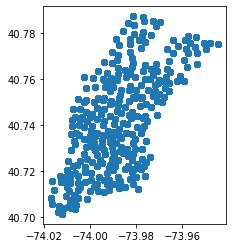

In [18]:
citibike_yearmonth.plot()
#len(citibike_yearmonth['start station id'].unique())

In [19]:
citibike_yearmonth['starttime'] = pd.to_datetime(citibike_yearmonth['starttime'])
citibike_yearmonth['starttime_rounded'] = citibike_yearmonth['starttime'].dt.floor('h')

In [20]:
citibike_yearmonth = citibike_yearmonth[citibike_yearmonth['tripduration'] <= 24 * 60 * 60]

In [21]:
len(citibike_yearmonth['end station id'].unique())

304

In [22]:
citibike_yearmonth

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,boro_name_left,boro_code_left,ntacode_right,shape_area_right,county_fips_right,ntaname_right,shape_leng_right,boro_name_right,boro_code_right,starttime_rounded
0,923,2016-01-01 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,...,Manhattan,1,MN25,19011710.2314,061,Battery Park City-Lower Manhattan,43726.8225623,Manhattan,1,2016-01-01 00:00:00
3,889,2016-01-01 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,...,Manhattan,1,MN25,19011710.2314,061,Battery Park City-Lower Manhattan,43726.8225623,Manhattan,1,2016-01-01 00:00:00
306,491,2016-01-01 01:01:32,1/1/2016 01:09:43,79,Franklin St & W Broadway,40.719116,-74.006667,363,West Thames St,40.708347,...,Manhattan,1,MN25,19011710.2314,061,Battery Park City-Lower Manhattan,43726.8225623,Manhattan,1,2016-01-01 01:00:00
313,1163,2016-01-01 01:03:33,1/1/2016 01:22:57,330,Reade St & Broadway,40.714505,-74.005628,319,Fulton St & Broadway,40.711066,...,Manhattan,1,MN25,19011710.2314,061,Battery Park City-Lower Manhattan,43726.8225623,Manhattan,1,2016-01-01 01:00:00
319,1118,2016-01-01 01:04:01,1/1/2016 01:22:39,330,Reade St & Broadway,40.714505,-74.005628,319,Fulton St & Broadway,40.711066,...,Manhattan,1,MN25,19011710.2314,061,Battery Park City-Lower Manhattan,43726.8225623,Manhattan,1,2016-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502902,1905,2016-01-31 15:45:19,1/31/2016 16:17:05,3142,1 Ave & E 62 St,40.761227,-73.960940,3177,W 84 St & Broadway,40.786795,...,Manhattan,1,MN12,34379942.2028,061,Upper West Side,29160.2062717,Manhattan,1,2016-01-31 15:00:00
503385,1324,2016-01-31 16:00:39,1/31/2016 16:22:43,3156,E 72 St & York Ave,40.766638,-73.953483,3170,W 84 St & Columbus Ave,40.785000,...,Manhattan,1,MN12,34379942.2028,061,Upper West Side,29160.2062717,Manhattan,1,2016-01-31 16:00:00
503399,1296,2016-01-31 16:01:10,1/31/2016 16:22:47,3156,E 72 St & York Ave,40.766638,-73.953483,3170,W 84 St & Columbus Ave,40.785000,...,Manhattan,1,MN12,34379942.2028,061,Upper West Side,29160.2062717,Manhattan,1,2016-01-31 16:00:00
506719,1172,2016-01-31 18:30:35,1/31/2016 18:50:07,3141,1 Ave & E 68 St,40.765005,-73.958185,3226,W 82 St & Central Park West,40.782750,...,Manhattan,1,MN12,34379942.2028,061,Upper West Side,29160.2062717,Manhattan,1,2016-01-31 18:00:00


In [23]:
citibike_yearmonth.groupby([citibike_yearmonth['starttime_rounded'], citibike_yearmonth['start station id'], citibike_yearmonth['end station id']]).count()

tripduration  starttime  \
starttime_rounded   start station id end station id                            
2016-01-01 00:00:00 116              495                        1          1   
                    127              509                        1          1   
                    160              295                        1          1   
                    161              438                        1          1   
                    168              325                        1          1   
...                                                           ...        ...   
2016-01-31 23:00:00 3156             3155                       1          1   
                    3160             3170                       1          1   
                    3165             3145                       1          1   
                    3170             497                        1          1   
                    3235             428                        1          1   

                                                     stoptime  \
starttime_rounded   start station id end station id             
2016-01-01 00:00:00 116              495                    1   
                    127              509                    1   
                    160              295                    1   
                    161              438                    1   
                    168              325                    1   
...                                                       ...   
2016-01-31 23:00:00 3156             3155                   1   
                    3160             3170                   1   
                    3165             3145                   1   
                    3170             497                    1   
                    3235             428                    1   

                                                     start station name  \
starttime_rounded   start station id end station id                       
2016-01-01 00:00:00 116              495                              1   
                    127              509                              1   
                    160              295                              1   
                    161              438                              1   
                    168              325                              1   
...                                                                 ...   
2016-01-31 23:00:00 3156             3155                             1   
                    3160             3170                             1   
                    3165             3145                             1   
                    3170             497                              1   
                    3235             428                              1   

                                                     start station latitude  \
starttime_rounded   start station id end station id                           
2016-01-01 00:00:00 116              495                                  1   
                    127              509                                  1   
                    160              295                                  1   
                    161              438                                  1   
                    168              325                                  1   
...                                                                     ...   
2016-01-31 23:00:00 3156             3155                                 1   
                    3160             3170                                 1   
                    3165             3145                                 1   
                    3170             497                                  1   
                    3235             428                                  1   

                                                     start station longitude  \
starttime_rounded   start station id end station id                            
20

In [24]:
graph = nx.from_pandas_edgelist(infrastructure.explode('neighbors'), source='PHYSICALID', target='neighbors')

In [25]:
length = len(nx.shortest_path(graph, 29, 226))

In [26]:
k = 10
for path in list(islice(nx.shortest_simple_paths(graph, 29, 226), k)):
    print(path)
    print(len(path))

[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 79163, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131996, 132002, 131998, 308, 132032, 1319, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 853, 228, 132031, 227, 226]
24
[29, 3, 5, 6, 24, 96795, 79608, 79609, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 176275, 132031, 227, 226]
24
[29, 173026, 131907, 131905, 131906, 131898, 131895, 131896, 131903, 174122, 174123, 177682, 177684, 179057, 179040, 185679, 131995, 131994, 131998, 308, 132032, 1319, 227, 226]
24
[2